In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [ ]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.01,
    "momentum" : 0.99,
    "weight_decay" : 3e-5,
    "epcohs":30,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-AllClass"
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]

In [3]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [4]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
f_alpha = (1-b)/(1-np.power(b,train_class_counts))
print(f_alpha)

[0.00143064 0.00320357 0.00319653 0.00323937 0.0038239  0.00244738
 0.00244738 0.003468   0.00375    0.00556448 0.01478441 0.04809698
 1.         0.00365007 0.01689033 0.00825881 0.00380244 0.00985004
 0.02090204 0.0268058  0.00482751 0.02374777 0.02132692 0.03274452
 0.01637033 0.00838066]


In [5]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [6]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [7]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [ ]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
# optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
optimizer = torch.optim.SGD(
    model.parameters(),
    momentum=args["momentum"],
    lr=args["lr"],
    nesterov=True,
    weight_decay=args["weight_decay"]
)
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : 2.6627366447448733 - CE loss : 2.6651643455028533 - dice loss : -0.00242770416312851

train avg metrics for epoch 0 :
avg dice : 0.0028254755280628947 - avg precision : 0.001765332493960159 - avg recall : 0.023603028628649554
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 1.6742011904716492 - CE loss : 1.6769375920295715 - dice loss : -0.002736397483386099

valid avg metrics for epoch 0 :
avg dice : 9.105109188746775e-05 - avg precision : 0.002562785877235001 - avg recall : 5.769967847299995e-05
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1)
total loss : 0.7949269384145736 - CE loss : 0.7975454509258271 - dice loss : -0.0026185139291919767

train avg metrics for epoch 1 :
avg dice : 1.2036775359630025e-05 - avg precision : 0.0003153192484751344 - avg recall : 7.775570375088136e-06
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 0.32262612879276276 - CE loss : 0.32508455365896227 - dice loss : -0.002458424400538206

valid avg metrics for epoch 1 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 1511.369385
encoders.0.layers.0.layers.0.bias: 0.082151
encoders.0.layers.0.layers.1.weight: 313.141937
encoders.0.layers.0.layers.1.bias: 469.959167
encoders.0.layers.1.layers.0.weight: 7636.408203
encoders.0.layers.1.layers.0.bias: 0.166454
encoders.0.layers.1.layers.1.weight: 419.955963
encoders.0.layers.1.layers.1.bias: 543.514099
encoders.1.layers.0.layers.0.weight: 4244.785645
encoders.1.layers.0.layers.0.bias: 0.058086
encoders.1.layers.0.layers.1.weight: 101.727493
encoders.1.layers.0.layers.1.bias: 91.936630
encoders.1.layers.1.layers.0.weight: 4282.299805
encoders.1.layers.1.layers.0.bias: 0.032675
encoders.1.layers.1.layers.1.weight: 80.955124
encoders.1.layers.1.layers.1.bias: 57.693684
encoders.2.layers.0.layers.0.weight: 1991.483398
encoders.2.layers.0.layers.0.bias: 0.024854
encoders.2.layers.0.layers.1.weight: 39.426636
encoders.2.layers.0.layers.1.bias: 33.901264
encoders.2.layers.1.layers.0.weight: 2125.4821

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : 0.22484105184674263 - CE loss : 0.22786443471908568 - dice loss : -0.0030233824369497596

train avg metrics for epoch 3 :
avg dice : 4.452649143490972e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.24587477818131448 - CE loss : 0.2492712289094925 - dice loss : -0.0033964507048949598

valid avg metrics for epoch 3 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.20274757713079453 - CE loss : 0.20851189911365509 - dice loss : -0.005764321039896459

train avg metrics for epoch 4 :
avg dice : 4.452667215785935e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.21434919983148576 - CE loss : 0.2217857226729393 - dice loss : -0.007436523679643869

valid avg metrics for epoch 4 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 1638.258423
encoders.0.layers.0.layers.0.bias: 0.143548
encoders.0.layers.0.layers.1.weight: 473.074707
encoders.0.layers.0.layers.1.bias: 473.362640
encoders.0.layers.1.layers.0.weight: 12910.770508
encoders.0.layers.1.layers.0.bias: 0.105286
encoders.0.layers.1.layers.1.weight: 848.584351
encoders.0.layers.1.layers.1.bias: 929.658142
encoders.1.layers.0.layers.0.weight: 15670.969727
encoders.1.layers.0.layers.0.bias: 0.117515
encoders.1.layers.0.layers.1.weight: 299.770660
encoders.1.layers.0.layers.1.bias: 275.466919
encoders.1.layers.1.layers.0.weight: 10080.900391
encoders.1.layers.1.layers.0.bias: 0.072931
encoders.1.layers.1.layers.1.weight: 192.389603
encoders.1.layers.1.layers.1.bias: 139.654770
encoders.2.layers.0.layers.0.weight: 4014.025391
encoders.2.layers.0.layers.0.bias: 0.048301
encoders.2.layers.0.layers.1.weight: 84.083366
encoders.2.layers.0.layers.1.bias: 76.129875
encoders.2.layers.1.layers.0.weight: 441

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.1764224299788475 - CE loss : 0.18610080629587172 - dice loss : -0.009678376480005682

train avg metrics for epoch 6 :
avg dice : 4.4530454082041806e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.19167991802096368 - CE loss : 0.20186337158083917 - dice loss : -0.010183453420177102

valid avg metrics for epoch 6 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 0.16831839293241502 - CE loss : 0.179346711486578 - dice loss : -0.01102831776253879

train avg metrics for epoch 7 :
avg dice : 4.452716308799118e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.1804998569190502 - CE loss : 0.1925512082874775 - dice loss : -0.012051351182162762

valid avg metrics for epoch 7 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 3692.346436
encoders.0.layers.0.layers.0.bias: 0.362114
encoders.0.layers.0.layers.1.weight: 850.729370
encoders.0.layers.0.layers.1.bias: 409.434784
encoders.0.layers.1.layers.0.weight: 20089.005859
encoders.0.layers.1.layers.0.bias: 0.349950
encoders.0.layers.1.layers.1.weight: 963.497986
encoders.0.layers.1.layers.1.bias: 998.557068
encoders.1.layers.0.layers.0.weight: 20150.507812
encoders.1.layers.0.layers.0.bias: 0.495944
encoders.1.layers.0.layers.1.weight: 555.528137
encoders.1.layers.0.layers.1.bias: 417.743835
encoders.1.layers.1.layers.0.weight: 18498.779297
encoders.1.layers.1.layers.0.bias: 0.161176
encoders.1.layers.1.layers.1.weight: 292.471130
encoders.1.layers.1.layers.1.bias: 194.340179
encoders.2.layers.0.layers.0.weight: 9291.025391
encoders.2.layers.0.layers.0.bias: 0.117214
encoders.2.layers.0.layers.1.weight: 189.733902
encoders.2.layers.0.layers.1.bias: 157.214081
encoders.2.layers.1.layers.0.weight: 9

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 0.15757011801004409 - CE loss : 0.17021664783358573 - dice loss : -0.012646529925987124

train avg metrics for epoch 9 :
avg dice : 4.4527403997713905e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.17031484395265578 - CE loss : 0.1836489424109459 - dice loss : -0.013334097294136881

valid avg metrics for epoch 9 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
1 => dice : 7.779618827396736e-14 p : 0.0 , r : 0.0
2 => dice : 7.042799096733734e-14 p : 0.0 , r : 0.0
3 => dice : 8.138749277384477e-14 p : 0.0 , r : 0.0
4 => dice : 1.142556779439377e-13 p : 0.0 , r : 0.0
5 => dice : 6.149040423977098e-14 p : 0.0 , r : 0.0
6 => dice : 5.6431178089774714e-14 p : 0.0 , r : 0.0
7 => dice : 6.754702862581813e-14 p : 0.0 , r : 0.0
8 => dice : 7.95045249795713e-14 p : 0.0 , r : 0.0
9 => dice : 1.0652804051207443e-13 p : 0.0 , r : 0.0
9a => dice : 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10)
total loss : 0.1542623981833458 - CE loss : 0.16772309601306915 - dice loss : -0.013460697289556265

train avg metrics for epoch 10 :
avg dice : 4.438967227986452e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : 0.16718168705701827 - CE loss : 0.18114751279354097 - dice loss : -0.013965824991464615

valid avg metrics for epoch 10 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : 0.15124495580792427 - CE loss : 0.16514528706669807 - dice loss : -0.013900331547483801

train avg metrics for epoch 11 :
avg dice : 4.4531638738933703e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : 0.16501833721995354 - CE loss : 0.1792705275118351 - dice loss : -0.014252191688865424

valid avg metrics for epoch 11 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : 0.14926814638078212 - CE loss : 0.16354552030563355 - dice loss : -0.014277374241501092

train avg metrics for epoch 12 :
avg dice : 4.4530277512941753e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : 0.16274941042065622 - CE loss : 0.17756956368684768 - dice loss : -0.014820154057815671

valid avg metrics for epoch 12 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13)
total loss : 0.14712847508490084 - CE loss : 0.16192813456058502 - dice loss : -0.014799659429118038

train avg metrics for epoch 13 :
avg dice : 4.45284764769504e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : 0.16126640811562537 - CE loss : 0.17639877200126647 - dice loss : -0.015132364770397543

valid avg metrics for epoch 13 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14)
total loss : 0.1458528006821871 - CE loss : 0.1608515739440918 - dice loss : -0.014998773271217942

train avg metrics for epoch 14 :
avg dice : 4.453072759236861e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : 0.1602895028889179 - CE loss : 0.17564112991094588 - dice loss : -0.01535162702202797

valid avg metrics for epoch 14 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15)
total loss : 0.14441592745482923 - CE loss : 0.15958876565098762 - dice loss : -0.015172837805002927

train avg metrics for epoch 15 :
avg dice : 4.452762564251928e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : 0.15853035748004912 - CE loss : 0.17418400570750237 - dice loss : -0.015653649903833868

valid avg metrics for epoch 15 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : 0.1431048507988453 - CE loss : 0.15863352179527282 - dice loss : -0.015528671201318503

train avg metrics for epoch 16 :
avg dice : 4.449815933140074e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : 0.15803418308496475 - CE loss : 0.17377921864390372 - dice loss : -0.015745035326108336

valid avg metrics for epoch 16 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 4632.679688
encoders.0.layers.0.layers.0.bias: 1.670255
encoders.0.layers.0.layers.1.weight: 560.274963
encoders.0.layers.0.layers.1.bias: 546.736023
encoders.0.layers.1.layers.0.weight: 12607.593750
encoders.0.layers.1.layers.0.bias: 0.500462
encoders.0.layers.1.layers.1.weight: 684.761841
encoders.0.layers.1.layers.1.bias: 624.229004
encoders.1.layers.0.layers.0.weight: 17233.757812
encoders.1.layers.0.layers.0.bias: 0.632667
encoders.1.layers.0.layers.1.weight: 495.604126
encoders.1.layers.0.layers.1.bias: 502.646790
encoders.1.layers.1.layers.0.weight: 20265.593750
encoders.1.layers.1.layers.0.bias: 0.324955
encoders.1.layers.1.layers.1.weight: 482.731689
encoders.1.layers.1.layers.1.bias: 339.079651
encoders.2.layers.0.layers.0.weight: 17177.085938
encoders.2.layers.0.layers.0.bias: 0.243939
encoders.2.layers.0.layers.1.weight: 322.664886
encoders.2.layers.0.layers.1.bias: 289.156860
encoders.2.layers.1.layers.0.weight: 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : 0.1412894744426012 - CE loss : 0.1570232392847538 - dice loss : -0.01573376522399485

train avg metrics for epoch 18 :
avg dice : 4.4597945450438594e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : 0.15591021701693536 - CE loss : 0.17208399027585983 - dice loss : -0.016173774423077703

valid avg metrics for epoch 18 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19)
total loss : 0.14029271885752678 - CE loss : 0.15616835467517376 - dice loss : -0.015875636069104075

train avg metrics for epoch 19 :
avg dice : 4.452800106107403e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : 0.15516752302646636 - CE loss : 0.17144409120082854 - dice loss : -0.016276570269837976

valid avg metrics for epoch 19 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
1 => dice : 7.779618827396736e-14 p : 0.0 , r : 0.0
2 => dice : 7.042799096733734e-14 p : 0.0 , r : 0.0
3 => dice : 8.138749277384477e-14 p : 0.0 , r : 0.0
4 => dice : 1.142556779439377e-13 p : 0.0 , r : 0.0
5 => dice : 6.149040423977098e-14 p : 0.0 , r : 0.0
6 => dice : 5.6431178089774714e-14 p : 0.0 , r : 0.0
7 => dice : 6.754702862581813e-14 p : 0.0 , r : 0.0
8 => dice : 7.95045249795713e-14 p : 0.0 , r : 0.0
9 => dice : 1.0652804051207443e-13 p : 0.0 , r : 0.0
9a => dic

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : 0.13904018111526967 - CE loss : 0.15512146949768066 - dice loss : -0.016081288307905197

train avg metrics for epoch 20 :
avg dice : 4.4529862653144846e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : 0.15424633845686914 - CE loss : 0.17076839059591292 - dice loss : -0.016522051161155106

valid avg metrics for epoch 20 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : 0.13810029223561288 - CE loss : 0.15444357968866826 - dice loss : -0.01634328793734312

train avg metrics for epoch 21 :
avg dice : 4.4462127105478156e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : 0.15358436852693558 - CE loss : 0.17018012329936028 - dice loss : -0.016595753422006965

valid avg metrics for epoch 21 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22)
total loss : 0.13722746193408966 - CE loss : 0.15368757396936417 - dice loss : -0.016460111364722252

train avg metrics for epoch 22 :
avg dice : 4.4527371420826756e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : 0.1536531016230583 - CE loss : 0.17031160965561867 - dice loss : -0.016658506309613585

valid avg metrics for epoch 22 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23)
total loss : 0.13662722170352937 - CE loss : 0.15324362739920616 - dice loss : -0.01661640607751906

train avg metrics for epoch 23 :
avg dice : 4.452774698168304e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : 0.15283399745821952 - CE loss : 0.1695929780602455 - dice loss : -0.016758980927988887

valid avg metrics for epoch 23 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : 0.13582838103175163 - CE loss : 0.1525683118402958 - dice loss : -0.01673993024043739

train avg metrics for epoch 24 :
avg dice : 4.4529568631068196e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : 0.1520795740187168 - CE loss : 0.16909231022000312 - dice loss : -0.017012735782191157

valid avg metrics for epoch 24 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : 0.13488570660352706 - CE loss : 0.15182118974626063 - dice loss : -0.01693548312410712

train avg metrics for epoch 25 :
avg dice : 4.4529880356133444e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : 0.15202857851982116 - CE loss : 0.1690194897353649 - dice loss : -0.01699091182090342

valid avg metrics for epoch 25 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26)
total loss : 0.13386095240712165 - CE loss : 0.15103382624685766 - dice loss : -0.01717287354171276

train avg metrics for epoch 26 :
avg dice : 4.470161177658584e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : 0.15070170685648918 - CE loss : 0.16802410110831262 - dice loss : -0.01732239327393472

valid avg metrics for epoch 26 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : 0.13345568798482418 - CE loss : 0.15064166761934758 - dice loss : -0.017185978358611465

train avg metrics for epoch 27 :
avg dice : 4.452750848769828e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : 0.15064153745770453 - CE loss : 0.1680083304643631 - dice loss : -0.017366793239489198

valid avg metrics for epoch 27 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : 0.1326257947087288 - CE loss : 0.15008829362690448 - dice loss : -0.017462499039247632

train avg metrics for epoch 28 :
avg dice : 4.4525721908865273e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : 0.14992098286747932 - CE loss : 0.16742577254772187 - dice loss : -0.017504789959639312

valid avg metrics for epoch 28 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29)
total loss : 0.13217256024479865 - CE loss : 0.14942388765513898 - dice loss : -0.017251327922567724

train avg metrics for epoch 29 :
avg dice : 4.4526039319215663e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : 0.1496226482093334 - CE loss : 0.16724464148283005 - dice loss : -0.01762199215590954

valid avg metrics for epoch 29 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
1 => dice : 7.779618827396736e-14 p : 0.0 , r : 0.0
2 => dice : 7.042799096733734e-14 p : 0.0 , r : 0.0
3 => dice : 8.138749277384477e-14 p : 0.0 , r : 0.0
4 => dice : 1.142556779439377e-13 p : 0.0 , r : 0.0
5 => dice : 6.149040423977098e-14 p : 0.0 , r : 0.0
6 => dice : 5.6431178089774714e-14 p : 0.0 , r : 0.0
7 => dice : 6.754702862581813e-14 p : 0.0 , r : 0.0
8 => dice : 7.95045249795713e-14 p : 0.0 , r : 0.0
9 => dice : 1.0652804051207443e-13 p : 0.0 , r : 0.0
9a => dice

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 2323.14it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

processing ./temp_script.py


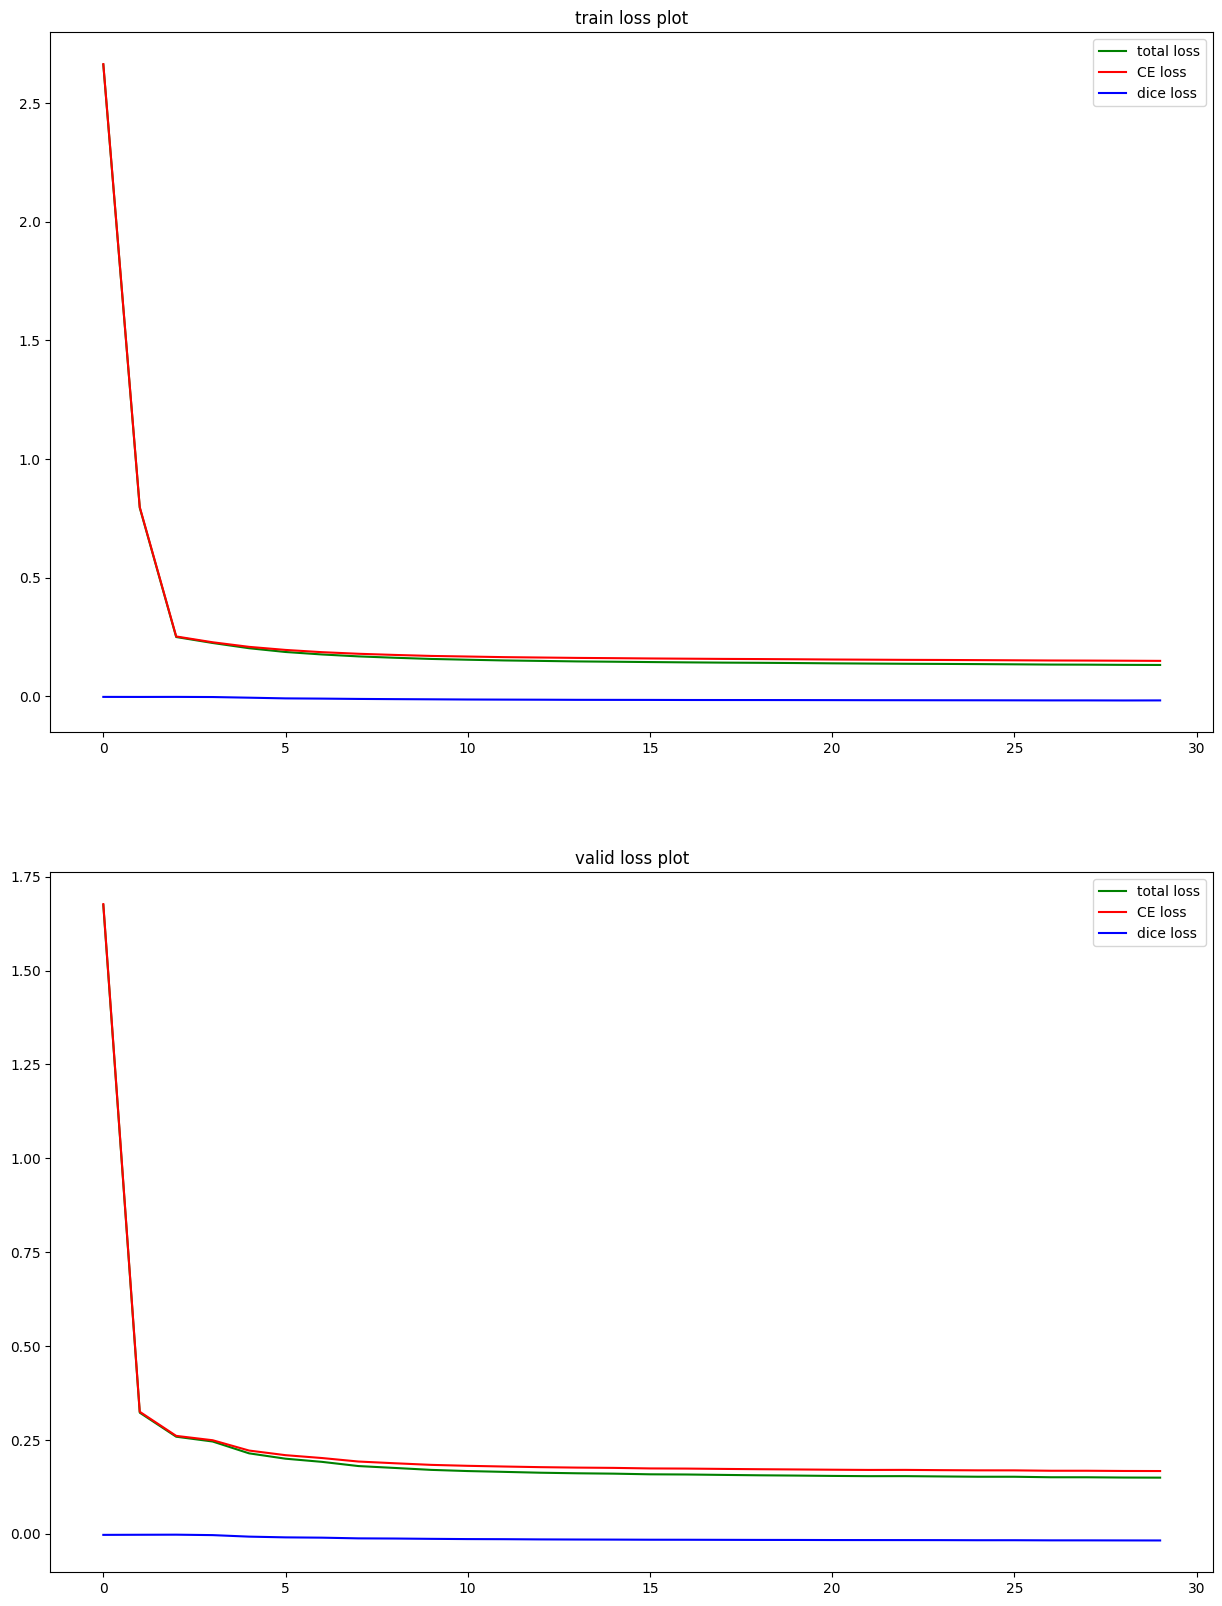

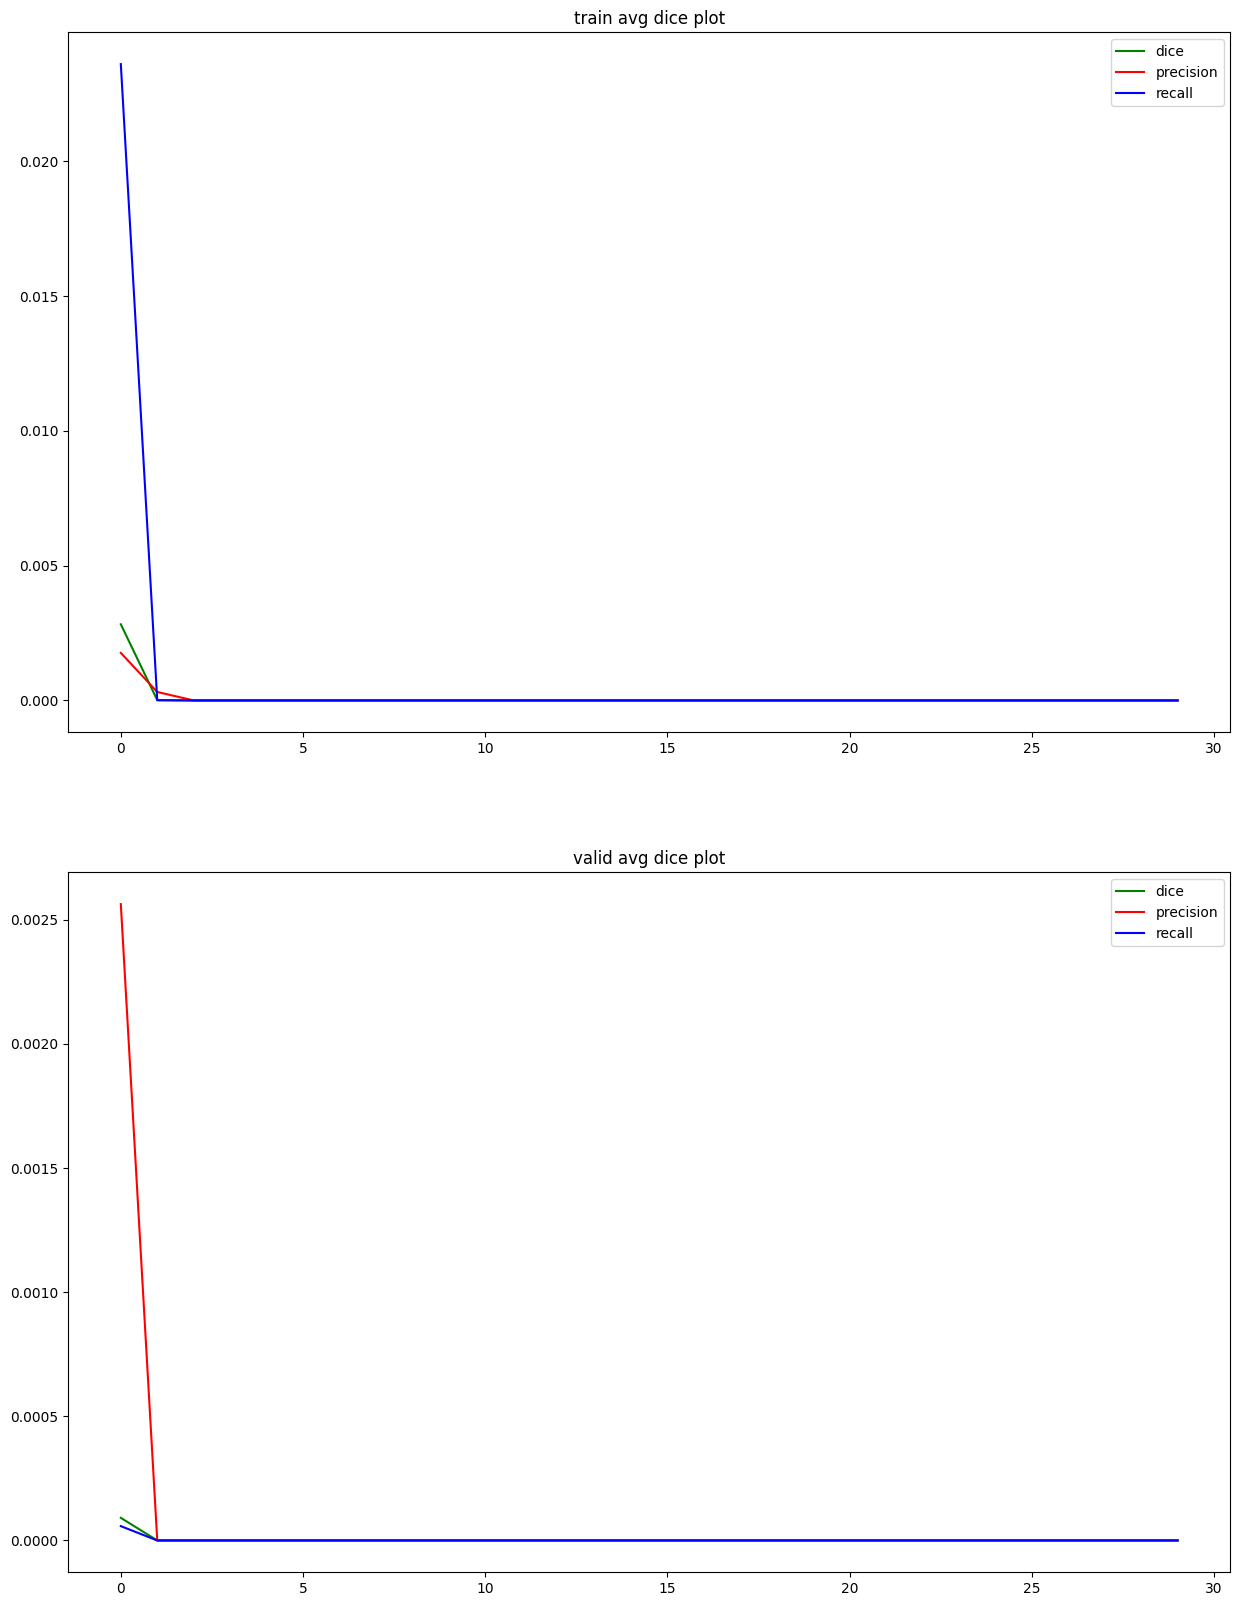

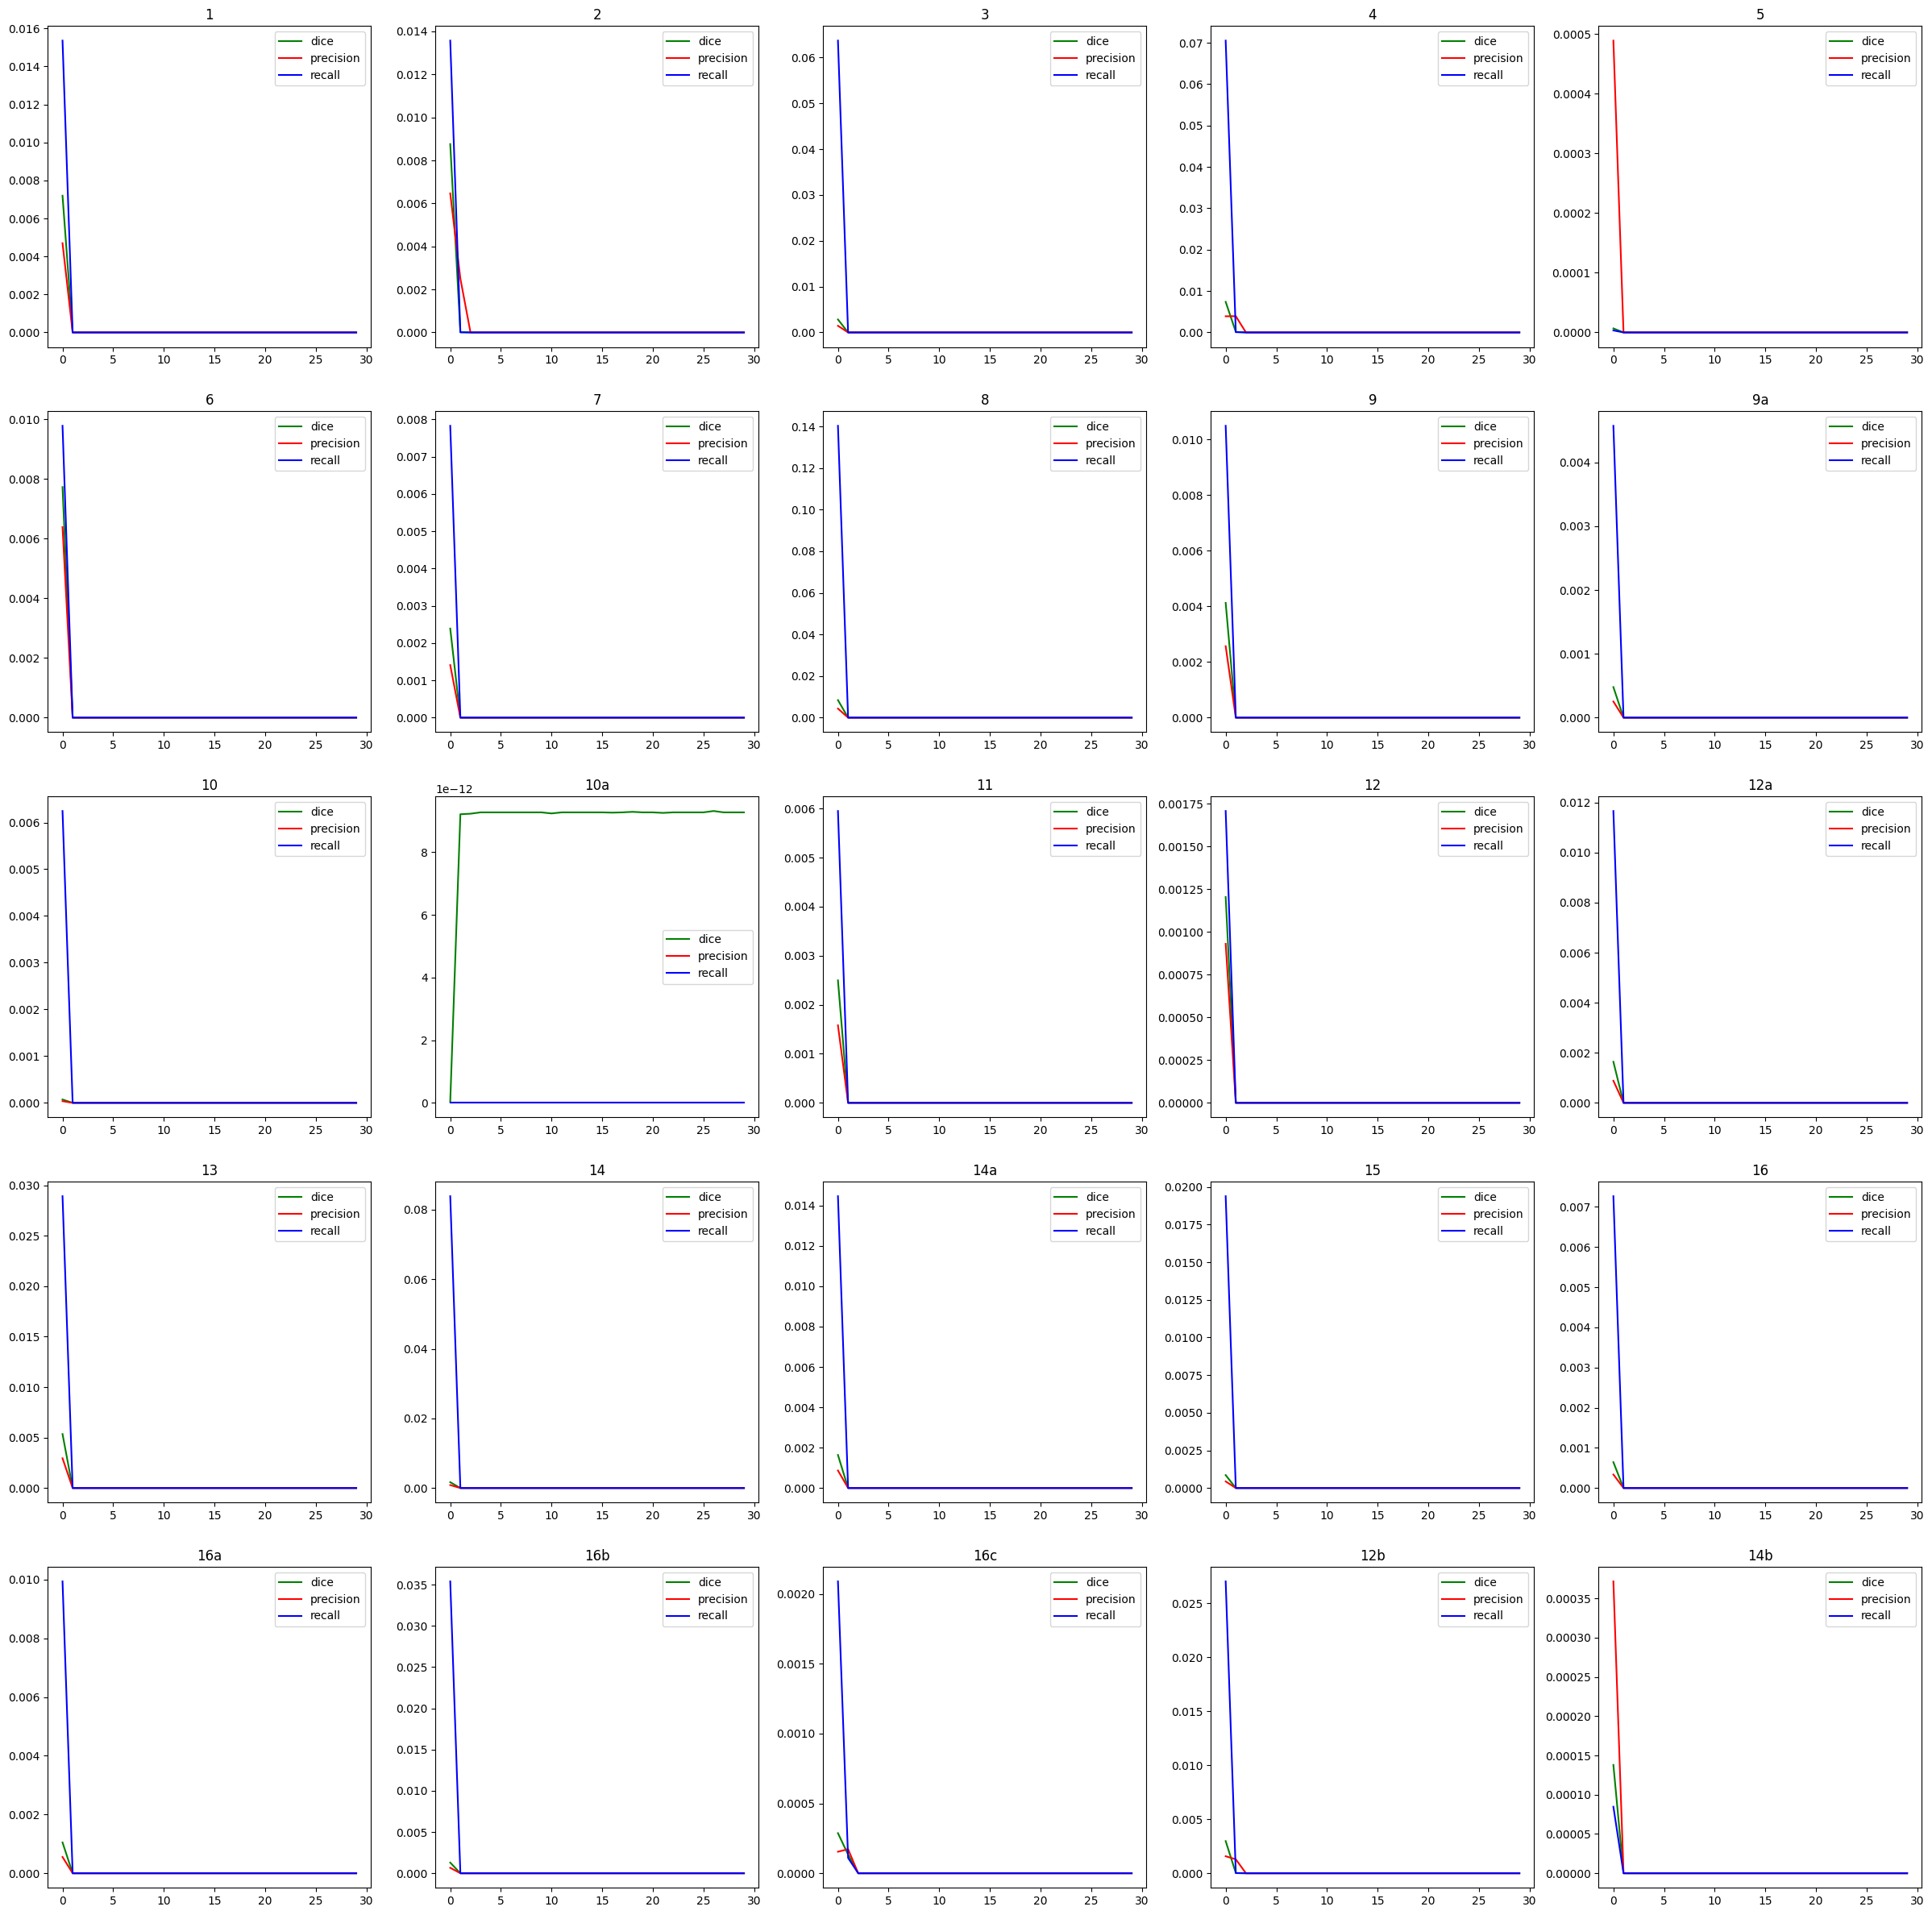

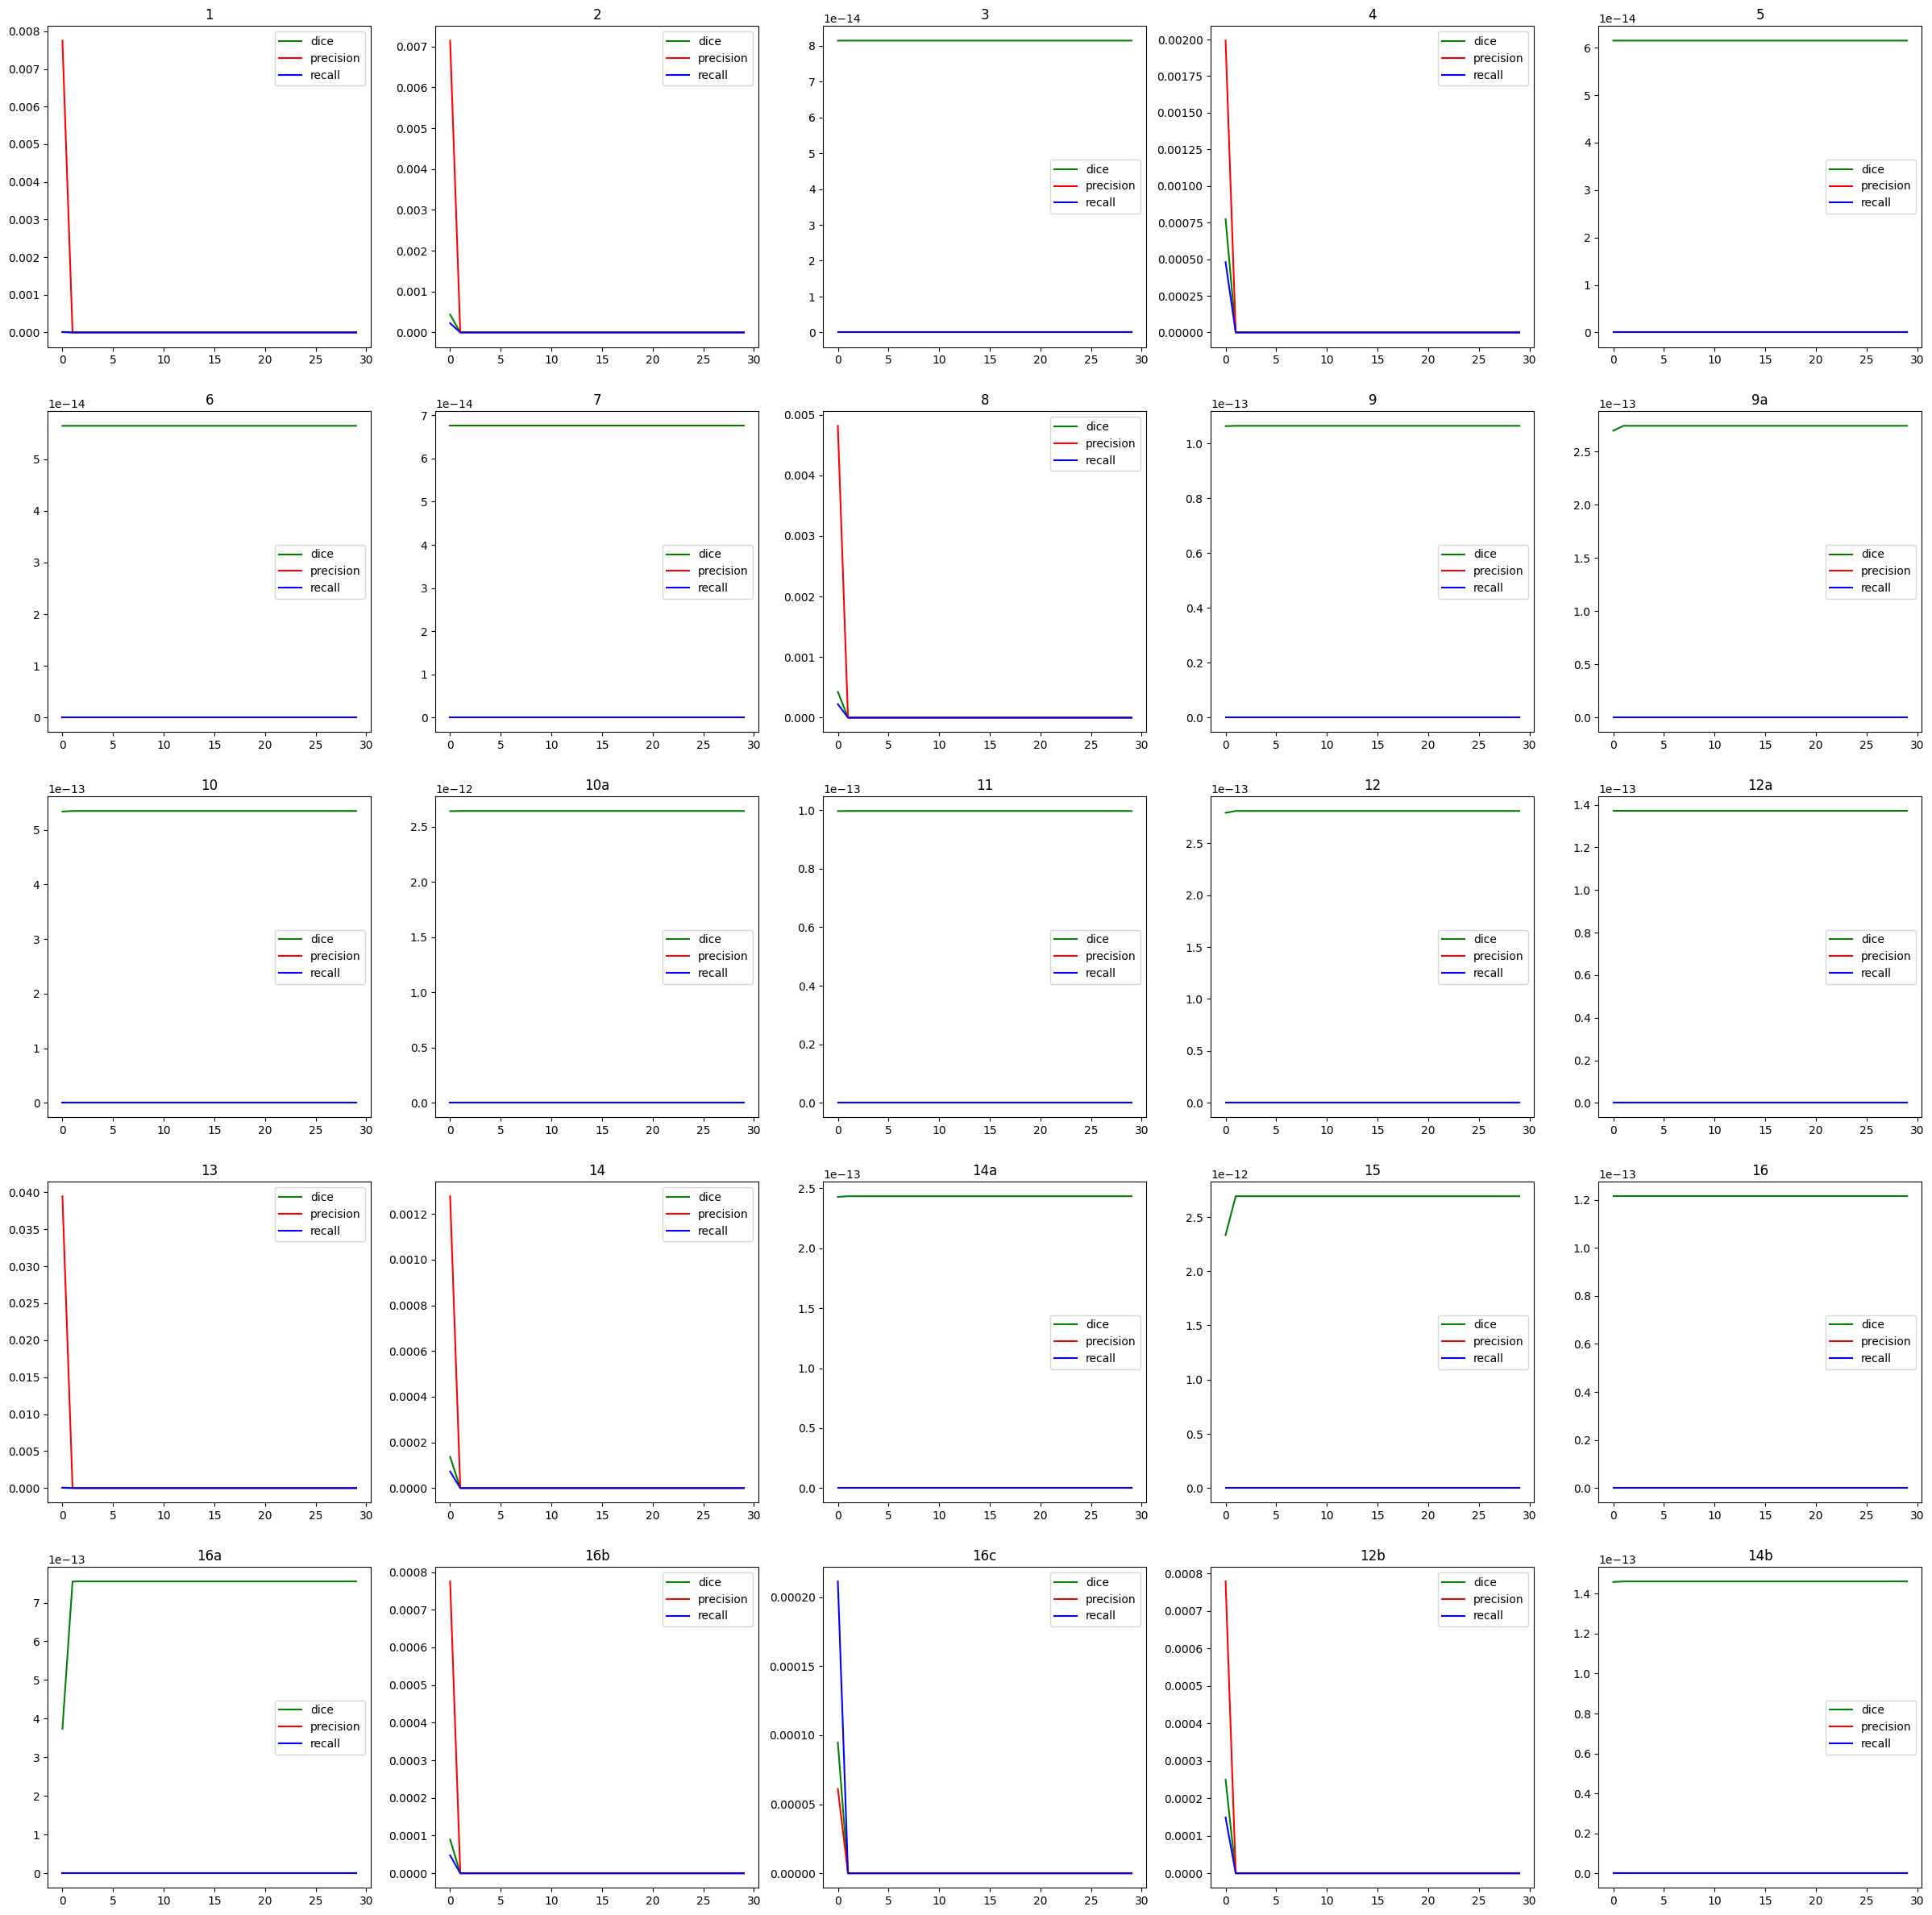

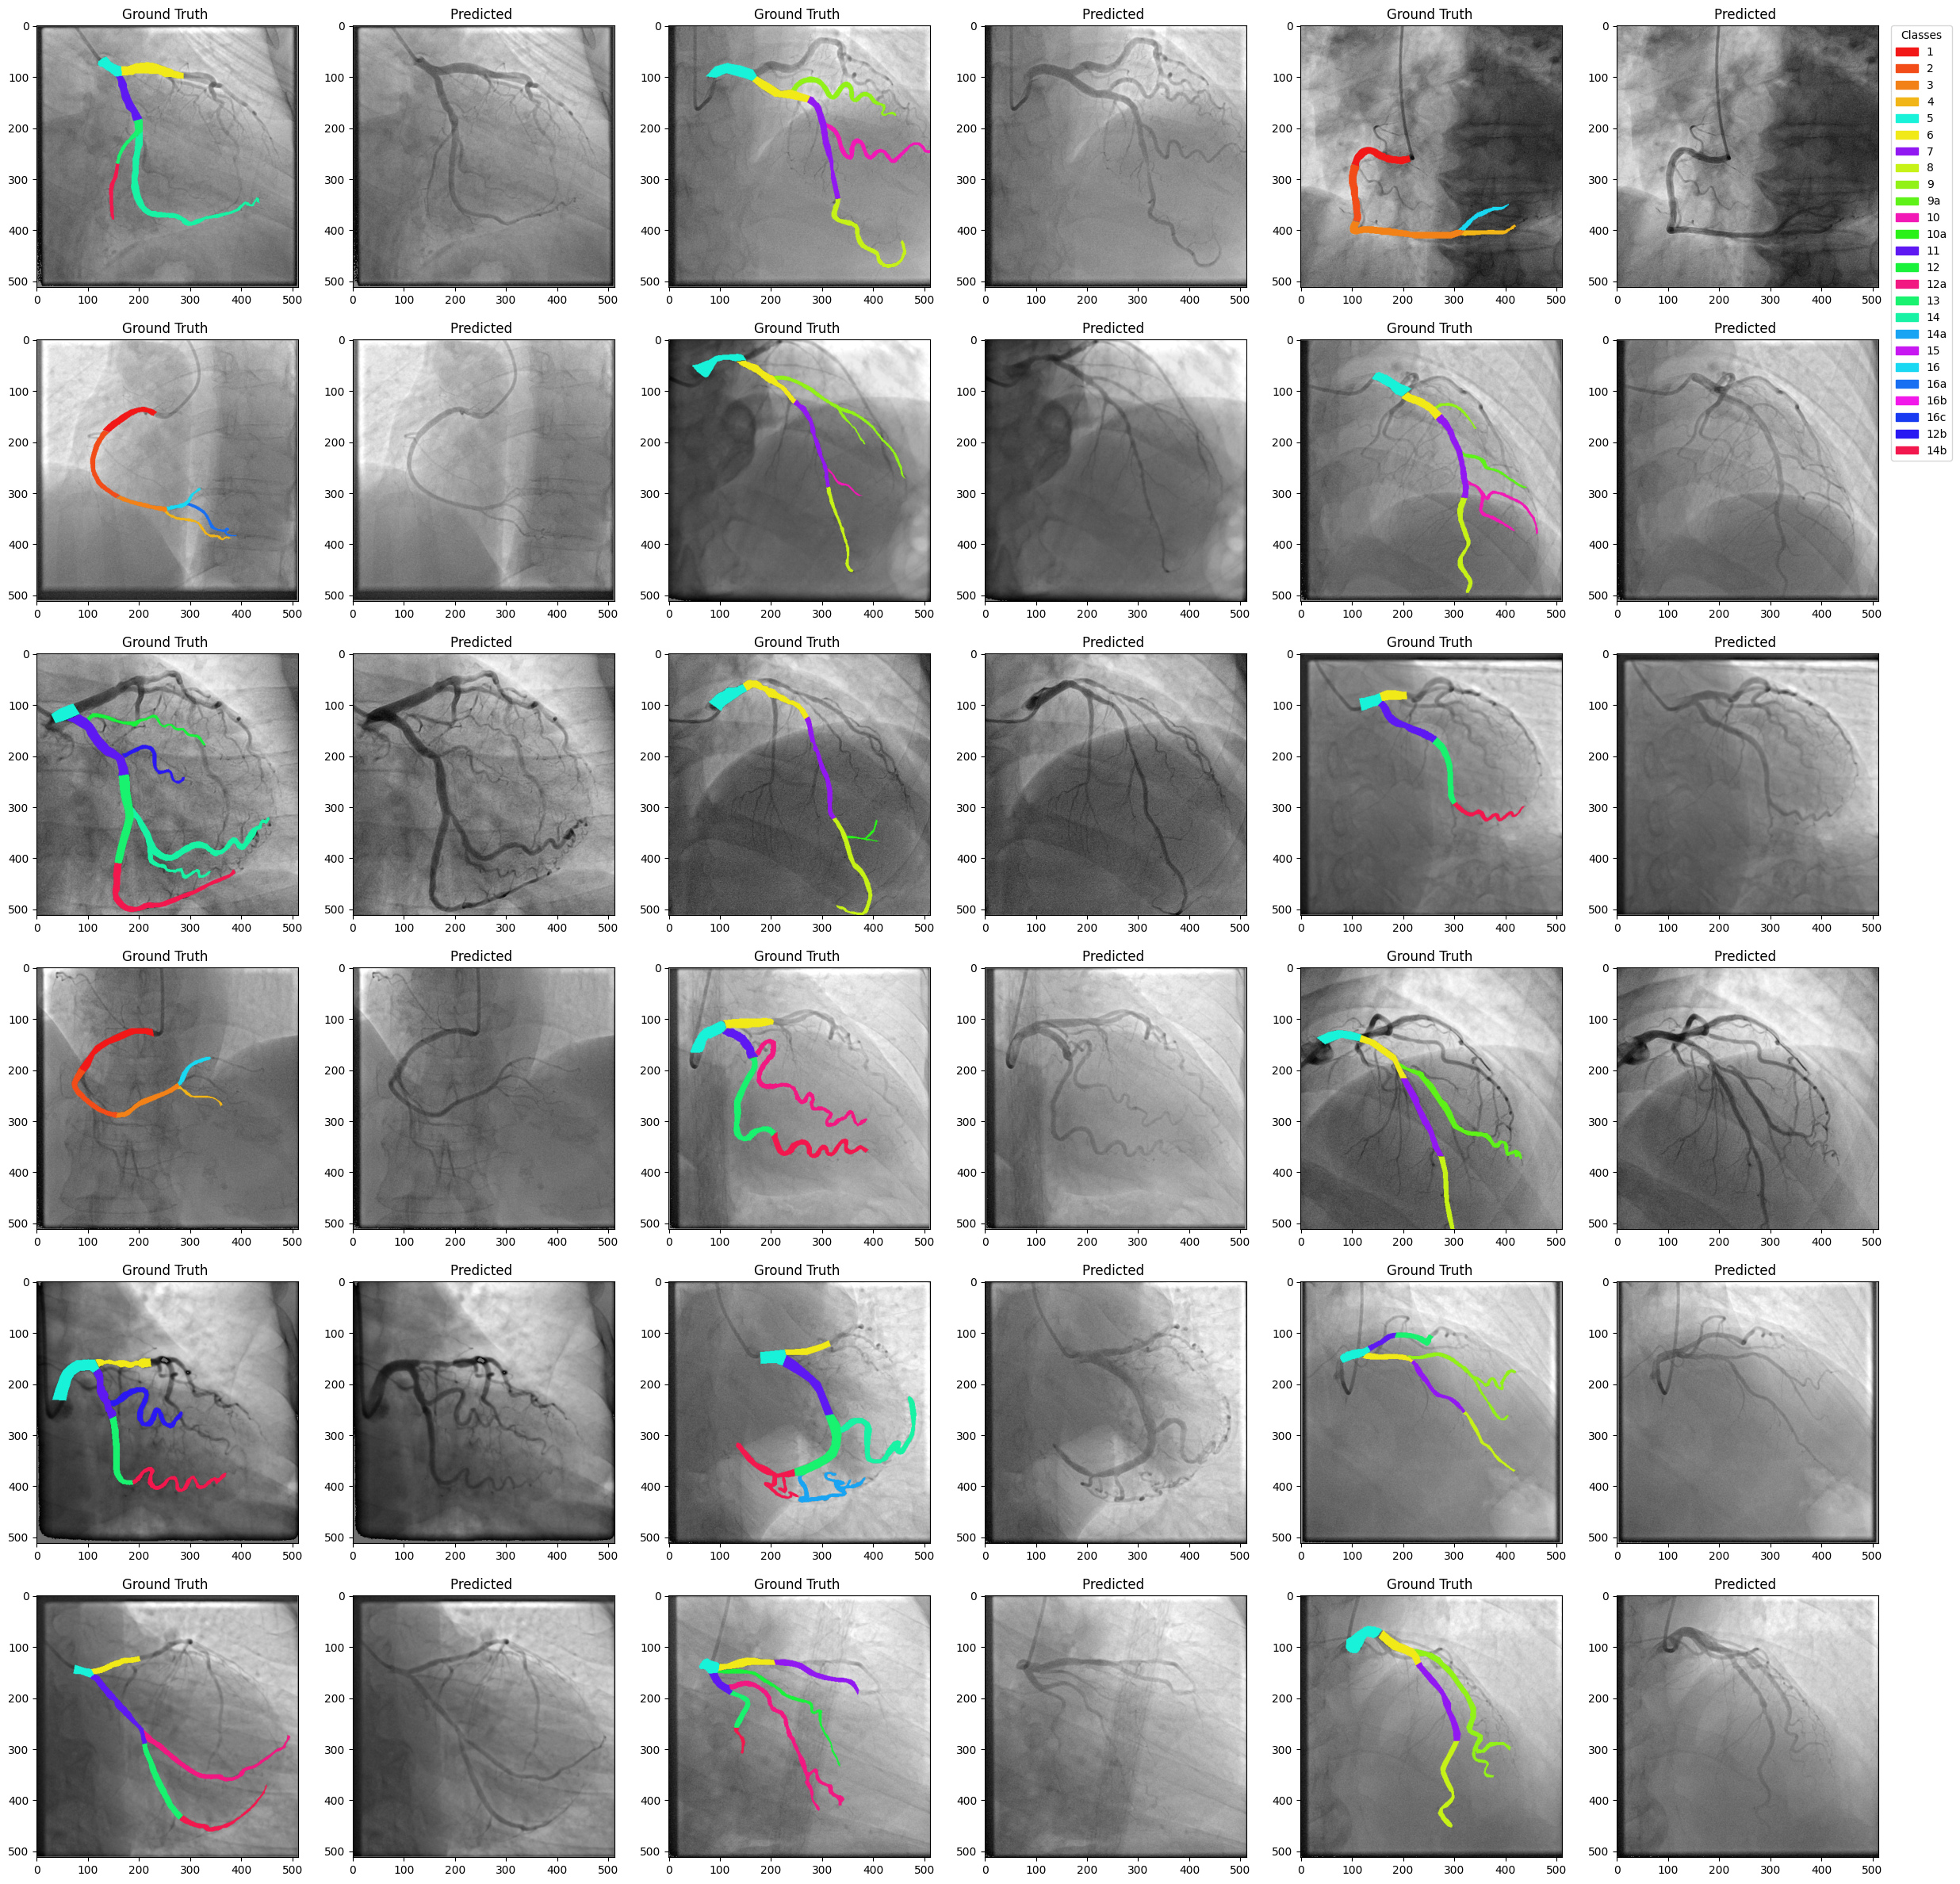

In [10]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)